In [34]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import lightgbm as lgb
import gc

import warnings
warnings.filterwarnings("ignore")

In [35]:
tourney_result = pd.read_csv('./ncaa/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MNCAATourneyCompactResults.csv')
tourney_seed = pd.read_csv('./ncaa/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MNCAATourneySeeds.csv')
tourney_result = tourney_result.drop(['DayNum', 'WScore', 'LScore', 'WLoc', 'NumOT'], axis=1)
tourney_result = pd.merge(tourney_result, tourney_seed, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
tourney_result.rename(columns={'Seed':'WSeed'}, inplace=True)
tourney_result = tourney_result.drop('TeamID', axis=1)
tourney_result = pd.merge(tourney_result, tourney_seed, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
tourney_result.rename(columns={'Seed':'LSeed'}, inplace=True)
tourney_result = tourney_result.drop('TeamID', axis=1)

In [36]:
def get_seed(x):
    return int(x[1:3])

tourney_result['WSeed'] = tourney_result['WSeed'].map(lambda x: get_seed(x))
tourney_result['LSeed'] = tourney_result['LSeed'].map(lambda x: get_seed(x))

In [37]:
season_result = pd.read_csv('./ncaa/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MRegularSeasonCompactResults.csv')
season_win_result = season_result[['Season', 'WTeamID', 'WScore']]
season_lose_result = season_result[['Season', 'LTeamID', 'LScore']]
season_win_result.rename(columns={'WTeamID':'TeamID', 'WScore':'Score'}, inplace=True)
season_lose_result.rename(columns={'LTeamID':'TeamID', 'LScore':'Score'}, inplace=True)
season_result = pd.concat((season_win_result, season_lose_result)).reset_index(drop=True)
season_score = season_result.groupby(['Season', 'TeamID'])['Score'].sum().reset_index()

In [38]:
tourney_result = pd.merge(tourney_result, season_score, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
tourney_result.rename(columns={'Score':'WScoreT'}, inplace=True)
tourney_result = tourney_result.drop('TeamID', axis=1)
tourney_result = pd.merge(tourney_result, season_score, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
tourney_result.rename(columns={'Score':'LScoreT'}, inplace=True)
tourney_result = tourney_result.drop('TeamID', axis=1)

In [39]:
tourney_win_result = tourney_result.drop(['Season', 'WTeamID', 'LTeamID'], axis=1)
tourney_win_result.rename(columns={'WSeed':'Seed1', 'LSeed':'Seed2', 
                                   'WScoreT':'ScoreT1', 'LScoreT':'ScoreT2'}, inplace=True)

In [40]:
tourney_lose_result = tourney_win_result.copy()
tourney_lose_result['Seed1'] = tourney_win_result['Seed2']
tourney_lose_result['Seed2'] = tourney_win_result['Seed1']
tourney_lose_result['ScoreT1'] = tourney_win_result['ScoreT2']
tourney_lose_result['ScoreT2'] = tourney_win_result['ScoreT1']

In [41]:
tourney_win_result['Seed_diff'] = tourney_win_result['Seed1'] - tourney_win_result['Seed2']
tourney_win_result['ScoreT_diff'] = tourney_win_result['ScoreT1'] - tourney_win_result['ScoreT2']
tourney_lose_result['Seed_diff'] = tourney_lose_result['Seed1'] - tourney_lose_result['Seed2']
tourney_lose_result['ScoreT_diff'] = tourney_lose_result['ScoreT1'] - tourney_lose_result['ScoreT2']

In [42]:
tourney_win_result['result'] = 1
tourney_lose_result['result'] = 0
tourney_result = pd.concat((tourney_win_result, tourney_lose_result)).reset_index(drop=True)
tourney_result

,Seed1,Seed2,ScoreT1,ScoreT2,Seed_diff,ScoreT_diff,result
0,9,8,2156,2092,1,64,1
1,11,6,2040,1728,5,312,1
2,1,16,2045,1907,-15,138,1
3,9,8,1933,1915,1,18,1
4,3,14,2281,1824,-11,457,1
...,...,...,...,...,...,...,...
4497,2,5,2532,2682,-3,-150,0
4498,1,2,2839,2680,-1,159,0
4499,2,3,2680,2339,-1,341,0
4500,5,1,2682,2299,4,383,0


In [43]:
test_df = pd.read_csv('./ncaa/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MSampleSubmissionStage1_2020.csv')


In [44]:
test_df['Season'] = test_df['ID'].map(lambda x: int(x[:4]))
test_df['WTeamID'] = test_df['ID'].map(lambda x: int(x[5:9]))
test_df['LTeamID'] = test_df['ID'].map(lambda x: int(x[10:14]))

In [45]:
test_df = pd.merge(test_df, tourney_seed, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
test_df.rename(columns={'Seed':'Seed1'}, inplace=True)
test_df = test_df.drop('TeamID', axis=1)
test_df = pd.merge(test_df, tourney_seed, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
test_df.rename(columns={'Seed':'Seed2'}, inplace=True)
test_df = test_df.drop('TeamID', axis=1)
test_df = pd.merge(test_df, season_score, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
test_df.rename(columns={'Score':'ScoreT1'}, inplace=True)
test_df = test_df.drop('TeamID', axis=1)
test_df = pd.merge(test_df, season_score, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
test_df.rename(columns={'Score':'ScoreT2'}, inplace=True)
test_df = test_df.drop('TeamID', axis=1)

In [46]:
test_df['Seed1'] = test_df['Seed1'].map(lambda x: get_seed(x))
test_df['Seed2'] = test_df['Seed2'].map(lambda x: get_seed(x))
test_df['Seed_diff'] = test_df['Seed1'] - test_df['Seed2']
test_df['ScoreT_diff'] = test_df['ScoreT1'] - test_df['ScoreT2']
test_df = test_df.drop(['ID', 'Pred', 'Season', 'WTeamID', 'LTeamID'], axis=1)
test_df


,Seed1,Seed2,ScoreT1,ScoreT2,Seed_diff,ScoreT_diff
0,14,2,2096,2599,12,-503
1,14,5,2096,2653,9,-557
2,14,3,2096,2212,11,-116
3,14,15,2096,2287,-1,-191
4,14,11,2096,2166,3,-70
...,...,...,...,...,...,...
11385,9,7,2374,2436,2,-62
11386,9,14,2374,2265,-5,109
11387,5,7,2279,2436,-2,-157
11388,5,14,2279,2265,-9,14


In [47]:
X = tourney_result.drop('result', axis=1)
y = tourney_result.result

In [48]:
params = {'num_leaves': 127,
          'min_data_in_leaf': 50,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.005,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'logloss',
          "verbosity": -1,
          'random_state': 42,
         }

In [49]:
NFOLDS = 10
folds = KFold(n_splits=NFOLDS)

columns = X.columns
splits = folds.split(X, y)
y_preds = np.zeros(test_df.shape[0])
y_oof = np.zeros(X.shape[0])

feature_importances = pd.DataFrame()
feature_importances['feature'] = columns
  
for fold_n, (train_index, valid_index) in enumerate(splits):
    print('Fold:',fold_n+1)
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200)
    
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    
    y_pred_valid = clf.predict(X_valid)
    y_oof[valid_index] = y_pred_valid
    
    y_preds += clf.predict(test_df) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Fold: 6
Fold: 7
Fold: 8
Fold: 9
Fold: 10


In [50]:
submission_df = pd.read_csv('./ncaa/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MSampleSubmissionStage1_2020.csv')
submission_df['Pred'] = y_preds
submission_df[:3]

,ID,Pred
0,2015_1107_1112,0.000869
1,2015_1107_1116,0.042785
2,2015_1107_1124,0.107589


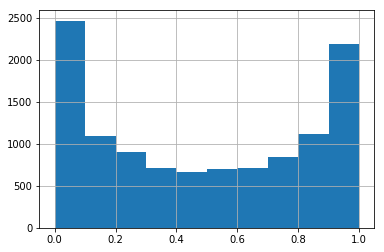

In [51]:
submission_df['Pred'].hist()

In [52]:
submission_df.to_csv('submission2.csv', index=False)